# Data cleaning 

In this section I'll perform further cleaning on the Data.

I will:

a) check the data for the accounting variables
    
    a.1) winzorize the outliers: these winsorized values may or may not be used in the thesis

b) replace missing values of variable "percent_foreign_rev" because it has too many missing values
  b1) a dummy variable equaling 1 if there was a replacement mada in that observation

c) setting industry dummies

d) On the industries, I'll run regressions to get the results for their coefficients versus the CARs

In [1]:
import pandas as pd
import numpy as np

from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

#for plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline


In [2]:
Data = pd.read_excel("./extractions.xlsx", sheet_name = "CAR")

C:\Users\jlbgo\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [3]:
Data.head(2)

,Firm,DS_Code,Cusip,Sic,Estimated CO2 Equivalents Emission Total - 2016,Estimated CO2 Equivalents Emission Total - 2017,Env_Score1,Env_Score1d,Env_Score1P,Env_Score1dP,...,Paris_Raw_5dd,Paris_Raw_9dd,Paris_CAPM_ret_3dd,Paris_CAPM_ret_5dd,Paris_CAPM_ret_9dd,Paris_FF_ret_3dd,Paris_FF_ret_5dd,Paris_FF_ret_9dd,FF_30Ind,FF_12Ind
0,AAON,544294,360206,3580,17295.0,15663.0,0.320325,0.418887,0.301594,0.417591,...,0.020609,-0.009052,0.003788,0.005559,-0.024633,-0.003938,-0.001068,-0.022581,13 - Fabricated Products and Machinery,03 - Manufacturing
1,AAR,923587,361105,3724,36493.0,36163.0,0.335031,0.438118,0.315482,0.436822,...,0.043624,0.029636,-0.001457,0.026583,0.012010,-0.006718,0.026093,0.022360,"16 - Aircraft, ships, and railroad equipment",03 - Manufacturing


In [4]:
len(Data.dropna())

847

# a): checking for outliers - winsorize

In [5]:
#The control variables are the following:
controls = ["ROA","CASH ETR","Log Market Cap", "Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR","FOREIGN SALES % TOTAL SALES"]

In [6]:
#Stats for these control variables:
Percentiles = Data.loc[:,controls].describe()
Percentiles

,ROA,CASH ETR,Log Market Cap,Debt_to_Equity,NET SALES/REVENUES -1YR ANN GR,FOREIGN SALES % TOTAL SALES
count,2545.000000,2132.000000,2550.000000,2541.000000,2471.000000,2215.000000
mean,-0.025769,0.210352,7.411326,0.839769,25.669834,21.857661
std,0.344509,0.186210,1.753630,7.432031,583.159961,28.196603
min,-9.417874,0.000000,1.403643,-139.443538,-157.180000,0.000000
25%,0.000205,0.046838,6.133875,0.106730,-2.930000,0.000000
50%,0.023823,0.208362,7.312714,0.570137,4.470000,5.820000
75%,0.060490,0.305666,8.534190,1.185614,14.510000,40.135000
max,2.103987,0.975992,13.291611,154.479281,28311.480000,149.720000


In [7]:
#For Outliers, let's use the Interquartile method
#Computing Interquartile range:
Percentiles.loc["IQR"] =  Percentiles.loc["75%"] - Percentiles.loc["25%"]

#Computing upper and lower limit:
Percentiles.loc["UpperLimit"] = Percentiles.loc["75%"] + 1.5*Percentiles.loc["IQR"]
Percentiles.loc["LowerLimit"] = Percentiles.loc["25%"] - 1.5*Percentiles.loc["IQR"]

In [8]:
#Let's winsorize the data for these:

#First I'll duplicate the controls, so we may still keep the non-winsorized data:
for control in controls:
    Data[control + "_winsorized"] = Data[control]

#dictionary of outliers:
outliers = dict()

#Lower limit
for control in controls:
    outliers[control] = [ "Lower: " + str(len(Data[control].loc[Data[control]<= Percentiles.loc["LowerLimit",control]]))]
    Data[control + "_winsorized"].loc[Data[control]<= Percentiles.loc["LowerLimit",control]] = Percentiles.loc["LowerLimit",control]

#Upper limit
for control in controls:
    outliers[control].append([ "Upper: " + str(len(Data[control].loc[Data[control]>= Percentiles.loc["UpperLimit",control]]))])
    Data[control + "_winsorized"].loc[Data[control]>= Percentiles.loc["UpperLimit",control]] = Percentiles.loc["UpperLimit",control]

C:\Users\jlbgo\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
outliers

{'ROA': ['Lower: 338', ['Upper: 126']],
 'CASH ETR': ['Lower: 0', ['Upper: 57']],
 'Log Market Cap': ['Lower: 2', ['Upper: 17']],
 'Debt_to_Equity': ['Lower: 97', ['Upper: 229']],
 'NET SALES/REVENUES -1YR ANN GR': ['Lower: 113', ['Upper: 209']],
 'FOREIGN SALES % TOTAL SALES': ['Lower: 0', ['Upper: 6']]}

In [10]:
+338/len(Data["ROA"])

0.13254901960784313

In [11]:
controls_winsorized = list()
for control in controls:
    controls_winsorized.append(control + "_winsorized")
controls_winsorized

['ROA_winsorized',
 'CASH ETR_winsorized',
 'Log Market Cap_winsorized',
 'Debt_to_Equity_winsorized',
 'NET SALES/REVENUES -1YR ANN GR_winsorized',
 'FOREIGN SALES % TOTAL SALES_winsorized']

In [12]:
Percentiles_winsorized = Data.loc[:,controls_winsorized].describe()

In [13]:
Percentiles

,ROA,CASH ETR,Log Market Cap,Debt_to_Equity,NET SALES/REVENUES -1YR ANN GR,FOREIGN SALES % TOTAL SALES
count,2545.000000,2132.000000,2550.000000,2541.000000,2471.000000,2215.000000
mean,-0.025769,0.210352,7.411326,0.839769,25.669834,21.857661
std,0.344509,0.186210,1.753630,7.432031,583.159961,28.196603
min,-9.417874,0.000000,1.403643,-139.443538,-157.180000,0.000000
25%,0.000205,0.046838,6.133875,0.106730,-2.930000,0.000000
50%,0.023823,0.208362,7.312714,0.570137,4.470000,5.820000
75%,0.060490,0.305666,8.534190,1.185614,14.510000,40.135000
max,2.103987,0.975992,13.291611,154.479281,28311.480000,149.720000
IQR,0.060285,0.258828,2.400315,1.078884,17.440000,40.135000
UpperLimit,0.150917,0.693908,12.134663,2.803940,40.670000,100.337500


In [14]:
Percentiles_winsorized

,ROA_winsorized,CASH ETR_winsorized,Log Market Cap_winsorized,Debt_to_Equity_winsorized,NET SALES/REVENUES -1YR ANN GR_winsorized,FOREIGN SALES % TOTAL SALES_winsorized
count,2545.000000,2132.000000,2550.000000,2541.000000,2471.000000,2215.000000
mean,0.023539,0.205045,7.409346,0.767408,6.517912,21.799239
std,0.064815,0.167812,1.744311,0.975158,17.030379,27.992575
min,-0.090223,0.000000,2.533402,-1.511596,-29.090000,0.000000
25%,0.000205,0.046838,6.133875,0.106730,-2.930000,0.000000
50%,0.023823,0.208362,7.312714,0.570137,4.470000,5.820000
75%,0.060490,0.305666,8.534190,1.185614,14.510000,40.135000
max,0.150917,0.693908,12.134663,2.803940,40.670000,100.337500


# b) replacement of missing values: "FOREIGN SALES % TOTAL SALES"

In [15]:
#There are too few observations on "Percent_Foreign_Revenues", so I will now put the blanks equaling zero

#A dummy will be created, equaling one in case I replaced those values with zero:
Data["Foreign_Sales_dummy"] = 0
#List with index values with nan:
nadinha = [*Data["FOREIGN SALES % TOTAL SALES"].loc[Data["FOREIGN SALES % TOTAL SALES"].isna()].index]

Data.loc[nadinha, "Foreign_Sales_dummy"] = 1

#Now, replacing the missing values for Percent_Foreign_Revenues with zero:
Data.loc[nadinha, "FOREIGN SALES % TOTAL SALES"] = 0
Data.loc[nadinha, "FOREIGN SALES % TOTAL SALES_winsorized"] = 0


In [16]:
#For the record, the amount replaced with zeros was:

sum(Data["Foreign_Sales_dummy"])

335

# c) dummies per Industry

In [17]:
dummies_12Ind = pd.get_dummies(Data["FF_12Ind"])
dummy_12Ind_list = [*dummies_12Ind.iloc[:,0:-1].columns] #all except one
dummies_12Ind.sum()

01 - Consumer Non-Durables    108
02 - Consumer Durables         49
03 - Manufacturing            217
04 - Energy                    82
05 - Chemicals                 66
06 - Business Equipment       341
07 - Telecomunication          63
08 - Utilities                 76
09 - Shops                    247
10 - Healthcare               310
11 - Money                    651
12 - Other                    340
dtype: int64

In [18]:
dummies_30Ind = pd.get_dummies(Data["FF_30Ind"])
dummy_30Ind_list = [*dummies_30Ind.iloc[:,0:-1].columns] #all except one
dummies_30Ind.sum()

01 - Food Products                                                  47
02 - Beer & Liquor                                                   8
03 - Tobacco Products                                                4
04 - Recreation                                                     39
05 - Printing and Publishing                                        22
06 - Consumer Goods                                                 42
07 - Apparel                                                        22
08 - Healthcare, Medical Equipment, Pharmaceutical Products        310
09 - Chemicals                                                      56
10 - Textiles                                                        5
11 - Construction and Construction Materials                        67
12 - Steel Works Etc                                                22
13 - Fabricated Products and Machinery                              80
14 - Electrical Equipment                                           23
15 - A

In [19]:
Data = Data.join(dummies_12Ind)

In [20]:
Data = Data.join(dummies_30Ind)

# d) Regressions per Industry

In [21]:
len(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list].dropna())

2468

In [39]:
Data.loc[:,dummy_30Ind_list].sum()

01 - Food Products                                                  47
02 - Beer & Liquor                                                   8
03 - Tobacco Products                                                4
04 - Recreation                                                     39
05 - Printing and Publishing                                        22
06 - Consumer Goods                                                 42
07 - Apparel                                                        22
08 - Healthcare, Medical Equipment, Pharmaceutical Products        310
09 - Chemicals                                                      56
10 - Textiles                                                        5
11 - Construction and Construction Materials                        67
12 - Steel Works Etc                                                22
13 - Fabricated Products and Machinery                              80
14 - Electrical Equipment                                           23
15 - A

In [23]:
#Regressions: coefficients per Industry
_30Ind_1d = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().params.loc[dummy_30Ind_list])
_30Ind_5d = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_5d"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().params.loc[dummy_30Ind_list])
_30Ind_dec16 = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_dec16"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().params.loc[dummy_30Ind_list])

C:\Users\jlbgo\Anaconda3\lib\site-packages\statsmodels\base\data.py:480: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


In [34]:
# P-values for these coefficients
_30Ind_1dpv = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().pvalues.loc[dummy_30Ind_list])
_30Ind_5dpv = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_5d"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().pvalues.loc[dummy_30Ind_list])
_30Ind_dec16pv = pd.DataFrame(sm.OLS(endog= Data["Trump_CAPM_ret_dec16"], exog= sm.add_constant(Data.loc[:,["ROA","Log Market Cap","Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR"] +dummy_30Ind_list]), missing='drop').fit().pvalues.loc[dummy_30Ind_list])

C:\Users\jlbgo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


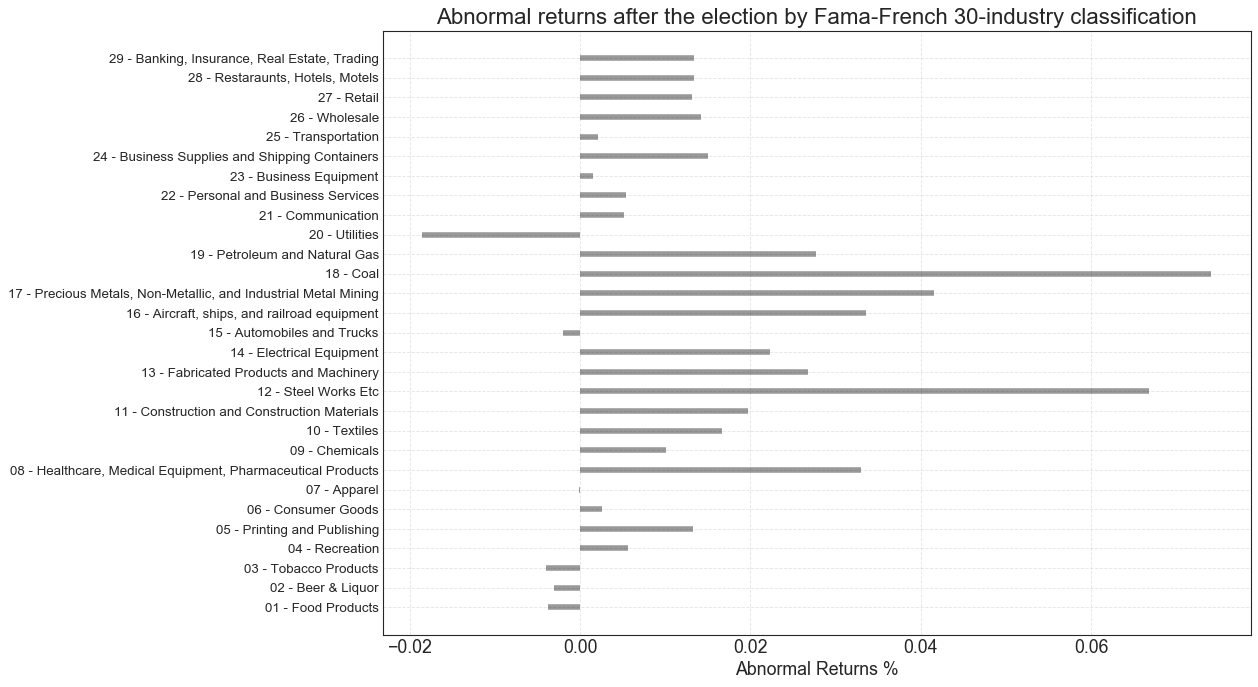

In [26]:
x = _30Ind_1d

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=_30Ind_1d.index, xmin=0, xmax=_30Ind_1d[0],  alpha=0.4, linewidth=5)


# Decorations
plt.gca().set( xlabel='Abnormal Returns %')
plt.yticks(_30Ind_1d.index, fontsize=12)
plt.title('Abnormal returns after the election by Fama-French 30-industry classification', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

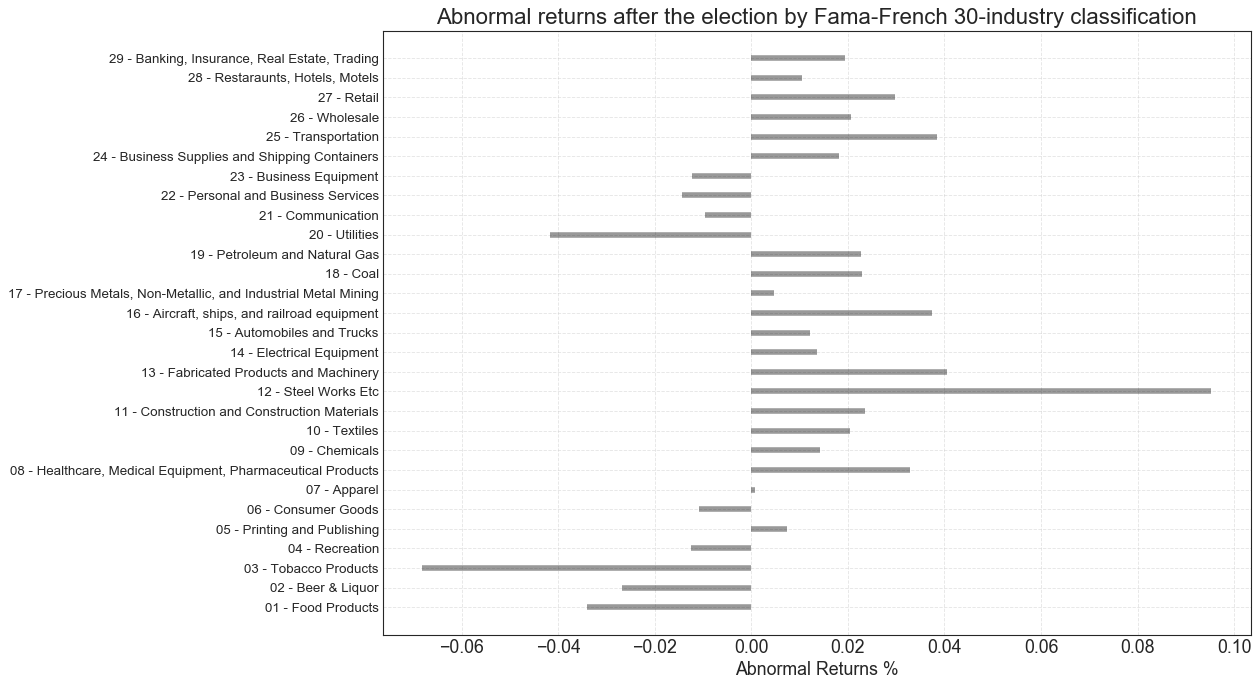

In [27]:
x = _30Ind_5d

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=_30Ind_5d.index, xmin=0, xmax=_30Ind_5d[0],  alpha=0.4, linewidth=5)


# Decorations
plt.gca().set( xlabel='Abnormal Returns %')
plt.yticks(_30Ind_5d.index, fontsize=12)
plt.title('Abnormal returns after the election by Fama-French 30-industry classification', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

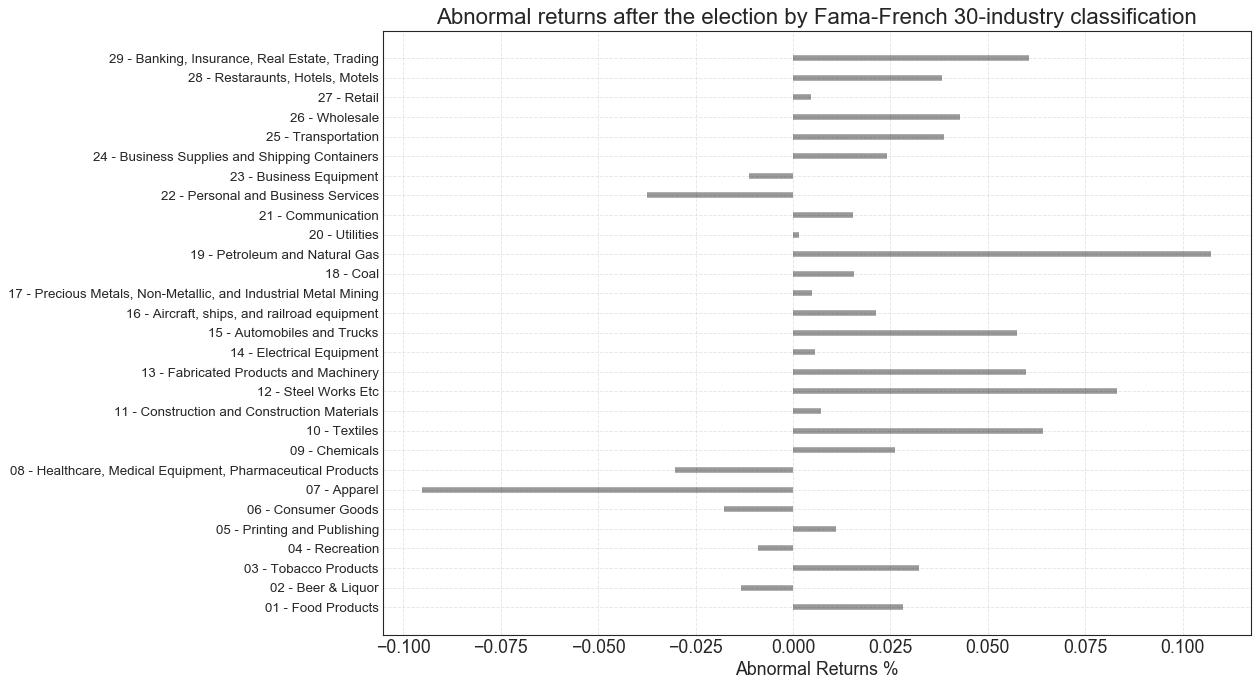

In [28]:
x = _30Ind_dec16

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=_30Ind_dec16.index, xmin=0, xmax=_30Ind_dec16[0],  alpha=0.4, linewidth=5)


# Decorations
plt.gca().set( xlabel='Abnormal Returns %')
plt.yticks(_30Ind_dec16.index, fontsize=12)
plt.title('Abnormal returns after the election by Fama-French 30-industry classification', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [41]:
#Creating Data Frame with the 3 together:
Industry30CAR = pd.DataFrame()

Industry30CAR["#firms"] = [*Data.loc[:,dummy_30Ind_list].sum()]

Industry30CAR.set_index(_30Ind_1d.index, inplace = True)

Industry30CAR["1d"] = _30Ind_1d[0]
Industry30CAR["5d"] = _30Ind_5d[0]
Industry30CAR["dec16"] = _30Ind_dec16[0]

Industry30CAR["1d_pvalue"] = _30Ind_1dpv[0]
Industry30CAR["5d_pvalue"] = _30Ind_5dpv[0]
Industry30CAR["dec16_pvalue"] = _30Ind_dec16pv[0]


Industry30CAR

,#firms,1d,5d,dec16,1d_pvalue,5d_pvalue,dec16_pvalue
01 - Food Products,47,-0.003817,-0.034135,0.028197,0.794412,0.223199,0.548673
02 - Beer & Liquor,8,-0.003037,-0.026798,-0.013217,0.878775,0.481761,0.836171
03 - Tobacco Products,4,-0.003996,-0.068246,0.032401,0.872224,0.151042,0.684476
04 - Recreation,39,0.005674,-0.012514,-0.008966,0.703036,0.660267,0.851125
05 - Printing and Publishing,22,0.013209,0.007302,0.011044,0.409496,0.811584,0.829865
06 - Consumer Goods,42,0.002582,-0.010770,-0.017782,0.861610,0.703861,0.708380
07 - Apparel,22,-0.000143,0.000824,-0.095121,0.992860,0.978527,0.064245
"08 - Healthcare, Medical Equipment, Pharmaceutical Products",310,0.033039,0.032920,-0.030334,0.014898,0.204491,0.485861
09 - Chemicals,56,0.010051,0.014266,0.026203,0.486264,0.605408,0.571694
10 - Textiles,5,0.016672,0.020506,0.064081,0.468608,0.641199,0.385443


In [30]:
Industry30CAR.to_excel("./Industry30CAR.xlsx")